In [1]:
from __future__ import print_function
import gensim
import gensim.models as g
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from scipy import spatial
import os
from scipy.spatial import distance
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import sent_tokenize, word_tokenize, pos_tag
import scipy
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from gensim.utils import simple_preprocess
import re
import codecs
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer
from scipy.spatial.distance import euclidean, pdist, squareform
from scipy import sparse
import csv
import pandas as pd
from nose.tools import assert_true
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import time
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

In [2]:
# Doc2Vec Model
model="ms/doc2vec.bin"
test_docs="data/test_docs.txt"
output_file="data/test_vectors.txt"
#parameters
start_alpha=0.01
infer_epoch=1000
#load model as 'd2v'
d2v = g.Doc2Vec.load(model)

In [3]:
#read test cases from a directory
folder = "test_specs_backup"
tcs = []
dis_mat = []
def all_file_content(directory_name):
    file_list = os.listdir(directory_name)
    for file_name in file_list:
        with open(os.path.join(directory_name, file_name), "r", encoding="utf8") as src_file:
            yield src_file.read().lower()
for file_content in all_file_content(folder):
    file_list = os.listdir(folder)
    tcs.append(file_content)

In [4]:
#tokenize and lemmatize files content
def tokenize(posts):
    tokenized_posts = []
    for row in posts:
        token = word_tokenize(row)
        if token != '':
            tokenized_posts.append(token)
    return tokenized_posts

def lemmatize(tokenized_posts):
    lemmatizer = WordNetLemmatizer()
    lemmatized_posts = []
    for sentence in tokenized_posts:
        tagged = pos_tag(sentence)
        lemmatized_sentence = []
        for word, tag in tagged:
            wntag = get_wordnet_pos(tag)
            if wntag is None:
                lemmatized_sentence.append(word)
            else:
                lemmatized_sentence.append(lemmatizer.lemmatize(word, pos=wntag))
        lemmatized_sentence = " ".join(lemmatized_sentence)
        lemmatized_posts.append(lemmatized_sentence)
    return lemmatized_posts

def stemSentence(sentence):
    porter =  PorterStemmer()
    token_words=word_tokenize(sentence)
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None
# print(stemSentence(tcs[1]))

In [5]:
#cleaning the input

#remove stop words
def remove_stop_words(text):
    return ' '.join([word for word in text.split(' ') if word.lower() not in STOP_WORDS])

#remove URLs
def cleanURL(data):
    regex=re.compile (r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    return regex.sub(' ', data)
#remove puncts
def remove_punc(post):
    new_post = ''
    for ch in post:
        new_post += checkForCH(ch)
    return new_post

def checkForCH(ch):
    CharToSpace = ',-'
    if ch.isalpha():
        return ch
    elif ch in (CharToSpace) or ch.isspace():
        return ' '
    else:
        return ''

# remove non-latin characters
def filterLatinAlphabet(data):
    regex = re.compile(r'[^\x00-\x7F\x80-\xFF\u0100-\u017F\u0180-\u024F\u1E00-\u1EFF]')
    return regex.sub('', data)

#remove non-english words
def load_words():
    with open('words_alpha.txt') as word_file:
        valid_words = set(word_file.read().split())

    return valid_words

def clean_nonenglish_words(sentence, vocabulary=load_words()):
    for word in sentence:
        if word.casefold() not in vocabulary or word == "w":
            sentence.remove(word)

def clean_nonenglish_words_printing(sentence, vocabulary=load_words()):
    for word in sentence:
        if word.casefold() not in vocabulary:
            sentence.remove(word)
            print(word, "not english")
        if word.casefold() in vocabulary:
            print(word, "ENGLISH")
            
def clean_sentence(sentence):
    sentence = filterLatinAlphabet(sentence)
    sentence = cleanURL(sentence)
    sentence = remove_punc(sentence)
    sentence = sentence.split()
    clean_nonenglish_words(sentence)
    return sentence

# lemmatized_text = stemSentence(tcs[1])
# print(clean_sentence(lemmatized_text))


In [6]:
# vetorizing
vectors = [d2v.infer_vector(clean_sentence(stemSentence(tc)), alpha=start_alpha, steps=infer_epoch) for tc in tcs]
vectors_sparse = sparse.csr_matrix(vectors)

In [7]:
# calculating pairwise distances and create the similarity matrix

distances = cosine_distances(vectors_sparse)
# print('pairwise dense output:\n {}\n'.format(distances))
distances_sparse = cosine_similarity(vectors_sparse)
# print('pairwise sparse output:\n {}\n'.format(distances_sparse))

#add headers to the distance matrix
df = pd.DataFrame(distances, index=file_list, columns=file_list)

#export distance matrix as .csv file
df.to_csv('d2v_dm_test_spec_backup.csv', index=True, header=True, sep=',')

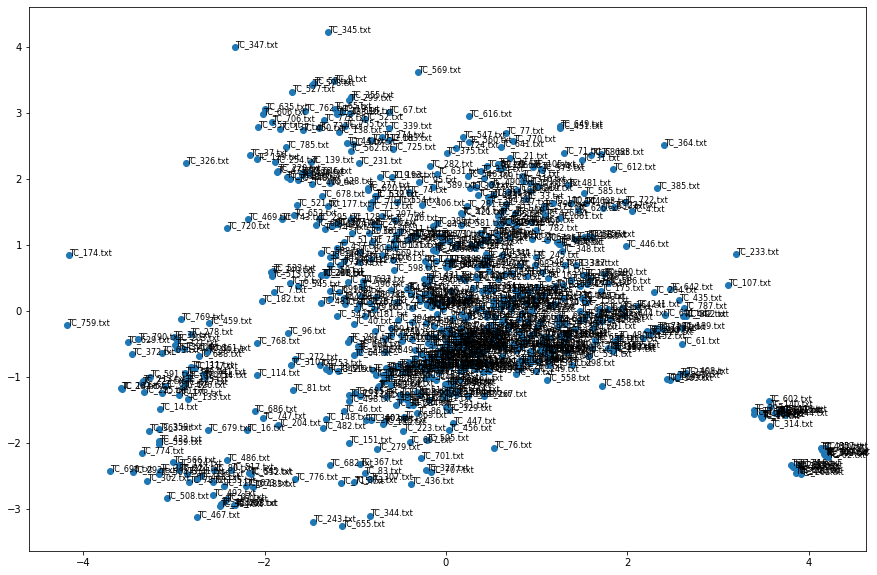

In [8]:
# intialise pca model and tell it to project data down onto 2 dimensions
pca = PCA(n_components=2)
pca.fit(vectors)
doc_vecs_2d = pca.transform(vectors)


# create a nice big plot 
plt.figure(figsize=(15,10))

# plot the scatter plot of where the words will be
plt.scatter(doc_vecs_2d[:,0], doc_vecs_2d[:,1])

# for each word and coordinate pair: draw the text on the plot
for tc, coord in zip(file_list, doc_vecs_2d):
    x, y = coord
    plt.text(x, y, tc, size= 8)

# show the plot
plt.show()

(70000, 784) (70000,)
